In [1]:
'''

array of x(Channels) by t(time)
f(x,t) = sin(t) (or 2pi*t/T)

'''

'\n\narray of x(Channels) by t(time)\nf(x,t) = sin(t) (or 2pi*t/T)\n\n'

In [11]:
import numpy as np
import tensorflow as tf
import random
import sys
import eli5

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

import d2d
import importlib
importlib.reload(d2d)
import pandas as pd
import os

2022-11-16 15:16:05.030292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 15:16:05.154304: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-16 15:16:05.183994: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 15:16:05.730782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

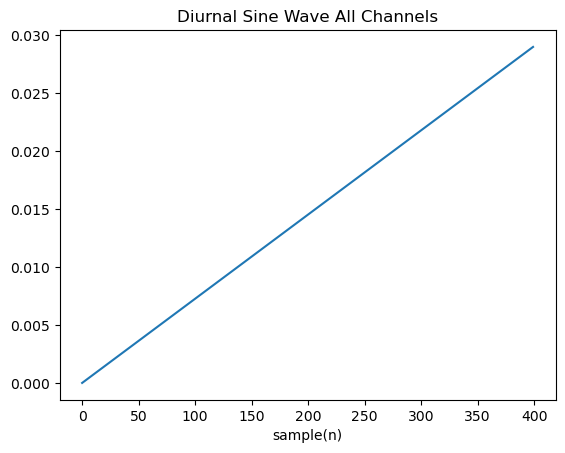

In [2]:
#Showing what a diurnal sine wave would look like.

import matplotlib.pyplot as plt
import numpy as np


Fs = 86400
f = 1
sample = 400
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)
#print(y)
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
plt.plot(x, y)
ax.set_xlabel('sample(n)')
ax.set_title('Diurnal Sine Wave All Channels')
plt.show()

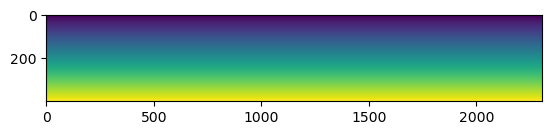

In [9]:
#Show what the DAS input looks like

arr = []

for i in y:
    arr.append([i]*2308)

sin_arr = np.asarray(arr)
sin_arr = np.reshape(sin_arr, (1, 400, 2308))

plt.imshow(sin_arr.squeeze())
plt.show()

In [13]:
# Now create the model

file = "/data/fast0/datasets/Rhone_data_continuous_highpass.h5"

filt = 'Highpass'

input_columns = list(np.arange(0, 2308, 1))

history = {}
val_performance = {}
performance = {}

#window_width = [1,2,5, 200]
#window_width = [350, 400, 450, 500]
ww = 200
bs = 32

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



linear_model, lstm_model, dnn_model, df_all_chan, das_data_all, f  = d2d.import_data(filename = file)

da = df_all_chan.to_numpy()

multi_step_window_shuffled = d2d.WindowGenerator(df_all_chan,
                                                input_width=ww,
                                                label_width=1, 
                                                shift=0,
                                                label_columns=['Discharge'],
                                                input_columns=input_columns,
                                                shuffle=True,
                                                batch_size=bs)

history['lstm_'+str(ww)+'_'+filt] = d2d.compile_and_fit(lstm_model, multi_step_window_shuffled, learning_rate = 0.001)

val_performance['lstm_'+str(ww)+'_'+filt] = lstm_model.evaluate(multi_step_window_shuffled.val)
performance['lstm_'+str(ww)+'_'+filt] = lstm_model.evaluate(multi_step_window_shuffled.test, verbose=0)

Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
2308
Epoch 1/1000
7/7 [==============================] - 2s 155ms/step - loss: 0.8885 - mean_absolute_error: 0.7713 - val_loss: 0.4671 - val_mean_absolute_error: 0.5267
Epoch 2/1000
7/7 [==============================] - 1s 94ms/step - loss: 0.4042 - mean_absolute_error: 0.5023 - val_loss: 0.3507 - val_mean_absolute_error: 0.4524
Epoch 3/1000
7/7 [==============================] - 1s 99ms/step - loss: 0.2825 - mean_absolute_error: 0.4138 - val_loss: 0.3426 - val_mean_absolute_error: 0.4245
Epoch 4/1000
7/7 [==============================] - 1s 89ms/step - loss: 0.1987 - mean_absolute_error: 0.3318 - val_loss: 0.2871 - val_mean_absolute_error: 0.3775
Epoch 5/1000
7/7 [==============================] - 1s 96ms/step - loss: 0.1438 - mean_absolute_error: 0.2804 - val_loss: 0.2575 - val_mean_absolute_error: 0.3356
Epoch 6/1000
7/7 [==============================] - 1s 95ms/step - loss: 0.1075 - mean_absolute_error: 0.2435 - val_loss: 0

In [31]:
#Loop over many periods

sine_ts = []

from fractions import Fraction
# fig, ax = plt.subplots()
# fig.patch.set_facecolor('white')

#period = [0.25,0.5,1,4,16,32,128, 512]

period = list(np.arange(0.001, 4, .01))
color = plt.cm.viridis(np.linspace(0,1,len(period)))
period = [1,2,4,8,16,32,64]
for p,c in zip(period,color):
    Fs = 86400/p
    f = 1
    sample = 400
    x = np.arange(sample)
    y = np.sin(2 * np.pi * f * x / Fs)
    arr = []

    for i in y:
        arr.append([i]*2308)

    sin_arr = np.asarray(arr)
    
    sin_arr = np.reshape(sin_arr, (1, 400, 2308))

    pred_sin = lstm_model.predict(sin_arr)
    
    sine_ts.append(pred_sin)
    
    #c= next(color)
    #plt.plot(pred_sin.squeeze(), label = 'period = '+str(Fraction(1/p))+'days', c=c)
    
# ax.set_xlabel('sample(n)')
# ax.set_title('Sine Wave All Channels')
# #ax.legend(bbox_to_anchor=(1.1, 1.05))
# plt.show()

1/1 [==============================] - 0s 63ms/step


In [32]:
sine_ts = np.asarray(sine_ts)
sine_ts.shape

(7, 1, 1)

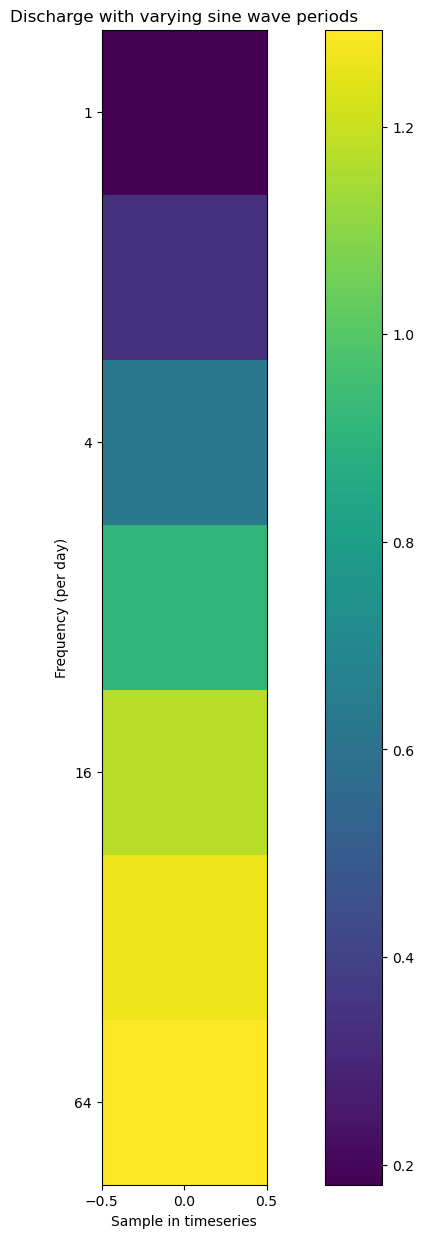

In [33]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(figsize=[15,15])
fig.patch.set_facecolor('white')
ax.set_ylabel('Frequency (per day)')
ax.set_xlabel('Sample in timeseries')
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.set_yticks(np.arange(len(period)))
ax.set_yticklabels(period)

ax.set_title('Discharge with varying sine wave periods')
plt.imshow(sine_ts)
plt.locator_params(axis='y', nbins=6)
plt.colorbar()
plt.show()